In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances # --> to register datasets in the COCO format;

# registering the both training and testing daatsets
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/train_imgs_png_0_11_21_31_41/train_imgs_0_11_21_31_41_COCO_JSON_Format_modified.json", "/content/drive/MyDrive/train_imgs_png_0_11_21_31_41")

register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/val_imgs_png_5_17/validation_imgs_5_17_COCO_JSON_Format.json", "/content/drive/MyDrive/val_imgs_png_5_17")


In [5]:
# extract the metadata and dataset dictionaries for both training datasets, can be used for visualizing, training, evaluation;
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[03/13 20:10:46 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/drive/MyDrive/train_imgs_png_0_11_21_31_41/train_imgs_0_11_21_31_41_COCO_JSON_Format_modified.json
[03/13 20:10:46 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/val_imgs_png_5_17/validation_imgs_5_17_COCO_JSON_Format.json


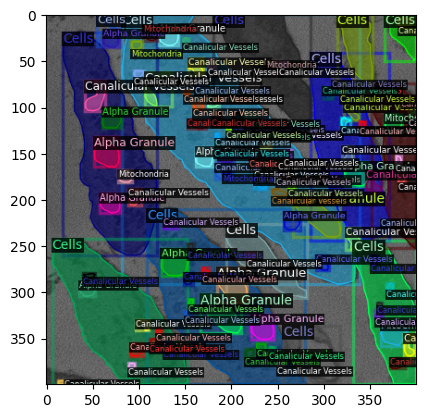

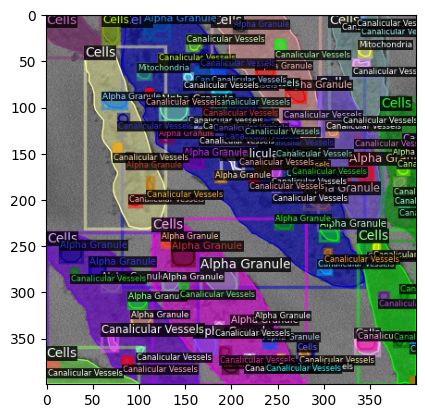

In [6]:
from matplotlib import pyplot as plt
for d in random.sample(train_dataset_dicts, 2): # visualizing 2 random image from the training set(5 images) using the data_dict and metadata;
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# this code states that, my annotation and the image of cell actually making sense;

In [7]:
# training begins;

In [8]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg() # defining a cofiguration;
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Output_Folders_Models" # defining the path of output folder models, where the model is gonna reside;
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) # pickinga pretarined model initially and telling it to update the weights as per my dataset, thus making  my own custom training(more like of a trainfer learning);
cfg.DATASETS.TRAIN = ("my_dataset_train",) # my daatset;
cfg.DATASETS.TEST = () # nil as i dont have any testing data right now;
cfg.DATALOADER.NUM_WORKERS = 2 # basically means parallel processing, ie. 2 tasks at a time;
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # initiating from pretarined weights instead of starting from stratch;
cfg.SOLVER.IMS_PER_BATCH = 2  # --> "batch size"
cfg.SOLVER.BASE_LR = 0.00025  #--> LR
cfg.SOLVER.MAX_ITER = 1500    # --> 1000 iterations
cfg.SOLVER.STEPS = []        # --> no LR
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # --> 4 classes --> cell, alpha granule, canalicular vessels, mitochondria; NO BACKGROUND --> bg will not be treated as 5th class;

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg) # --> instance of DefaultTrainer with the earlier defined config.;

trainer.resume_or_load(resume=False) #--> load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available;


[03/13 20:11:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 199MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


In [9]:
trainer.train() # the training;

[03/13 20:13:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/13 20:13:36 d2.utils.events]:  eta: 0:10:11  iter: 19  total_loss: 7.972  loss_cls: 1.504  loss_box_reg: 0.6379  loss_mask: 0.6927  loss_rpn_cls: 4.72  loss_rpn_loc: 0.4647    time: 0.4161  last_time: 0.3943  data_time: 0.0445  last_data_time: 0.0116   lr: 4.9953e-06  max_mem: 1820M
[03/13 20:13:48 d2.utils.events]:  eta: 0:09:53  iter: 39  total_loss: 4.55  loss_cls: 1.471  loss_box_reg: 0.5651  loss_mask: 0.6903  loss_rpn_cls: 1.413  loss_rpn_loc: 0.4209    time: 0.4056  last_time: 0.3949  data_time: 0.0084  last_data_time: 0.0124   lr: 9.9902e-06  max_mem: 1820M
[03/13 20:13:56 d2.utils.events]:  eta: 0:09:44  iter: 59  total_loss: 3.336  loss_cls: 1.384  loss_box_reg: 0.467  loss_mask: 0.6862  loss_rpn_cls: 0.4379  loss_rpn_loc: 0.3917    time: 0.4083  last_time: 0.4293  data_time: 0.0101  last_data_time: 0.0106   lr: 1.4985e-05  max_mem: 1820M
[03/13 20:14:04 d2.utils.events]:  eta: 0:09:39  iter: 79  total_loss: 3.032  loss_cls: 1.153  loss_box_reg: 0.4522  loss_mask: 0.6784 

In [10]:
# saving this trained(by me) yaml file for future use, just like saving ml models as .hdf5;
import yaml
config_yaml_path = "/content/drive/MyDrive/Output_Folders_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/drive/MyDrive/Output_Folders_Models/model_final.pth")  # model_final.pth--> path to the model i just trained;
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[03/13 20:25:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/Output_Folders_Models/model_final.pth ...


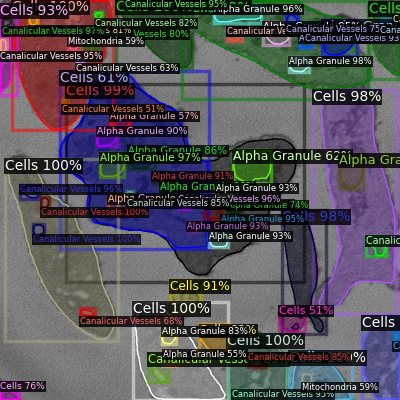

In [13]:
# verifying segmentation on random validation images;
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1): # 1 --> select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # removing the colors of unsegmented pixels; this option is only available for segmentation models;
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
# average precision, cell and everything else;
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[03/13 20:28:35 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[03/13 20:28:35 d2.data.datasets.coco]: Loaded 2 images in COCO format from /content/drive/MyDrive/val_imgs_png_5_17/validation_imgs_5_17_COCO_JSON_Format.json
[03/13 20:28:35 d2.data.build]: Distribution of instances among all 4 categories:
|   category    | #instances   |   category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:------------:|:-------------|:-------------:|:-------------|
|     Cells     | 28           | Mitochondria | 17           | Alpha Granule | 31           |
| Canalicular.. | 58           |              |              |               |              |
|     total     | 134          |              |              |               |              |
[03/13 20:28:35 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice

In [15]:
# selecting a new external image from test-folder;
new_im = cv2.imread("/content/drive/MyDrive/test_imgs_no_without_ground_truth_serial/test_image_16.png")
outputs  = predictor(new_im)

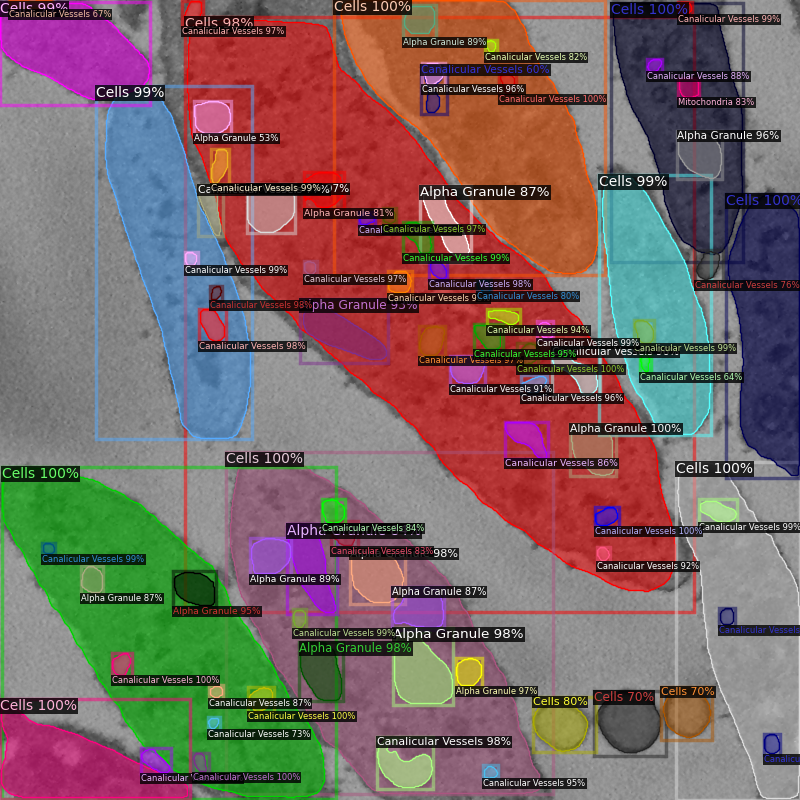

In [16]:
# segmenting;
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

In [17]:
input_images_directory = "/content/drive/MyDrive/test_imgs_no_without_ground_truth_serial" # --> external test images;

output_directory = "/content/drive/MyDrive/predicted_segmentation_output_of_test_images"  # --> where the segmented images will be saved

for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    outputs = predictor(new_im)  # Perform prediction on the new image

    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])  # Save the segmented image

print("Segmentation of all images completed.")

Segmentation of all images completed.


In [18]:
import csv
from skimage.measure import regionprops, label

input_images_directory = "/content/drive/MyDrive/test_imgs_no_without_ground_truth_serial"

output_csv_path = "/content/drive/MyDrive/predicted_segmentation_output_of_test_images/output_recognized_objects.csv"  # where the CSV file will be saved

with open(output_csv_path, 'w', newline='') as csvfile: # opening the CSV file for writing
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1  # Object number starts from 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = train_metadata.thing_classes[class_label]
            else:
                # If class label is not available (should not happen), use 'Unknown' as class name
                class_name = 'Unknown'

            # Write the object-level information to the CSV file
            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])  # Add more columns as needed for other properties

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


In [ ]:
# generating plots out of that csv file;

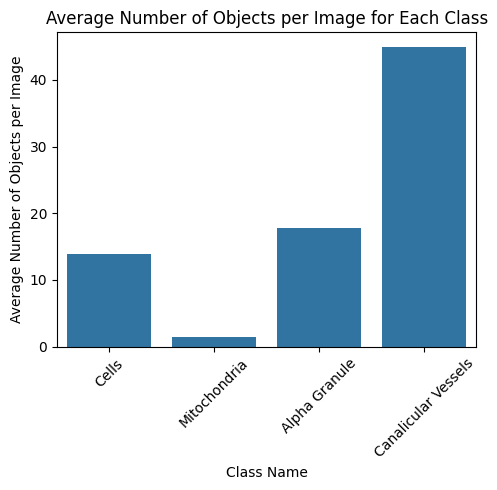

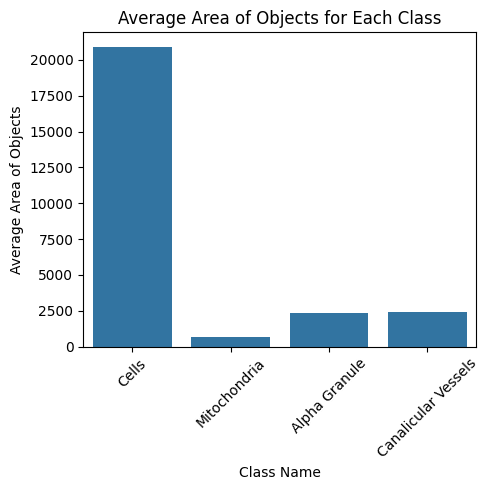

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path to the CSV file containing the object-level information
csv_file_path = "/content/drive/MyDrive/predicted_segmentation_output_of_test_images/output_recognized_objects.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file_path)

# Get class names from train_metadata.thing_classes
class_names = train_metadata.thing_classes

# Group the data by both "File Name" and "Class Name" and calculate the average number of objects per image for each class
# first group the data by both "File Name" and "Class Name" and count the number of objects within each group.
#Then, group the data by "Class Name" only and calculate the mean of the counts, which gives us the average number of objects per image for each class.
avg_objects_per_class = df.groupby(["File Name", "Class Name"])["Object Number"].count().reset_index()
avg_objects_per_class = avg_objects_per_class.groupby("Class Name")["Object Number"].mean().reset_index()

# Plot: Average number of objects per image for each class
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Object Number", data=avg_objects_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Number of Objects per Image")
plt.title("Average Number of Objects per Image for Each Class")
plt.tight_layout()
plt.show()


# Group the data by class and calculate the average area of objects for each class
avg_area_per_class = df.groupby("Class Name")["Area"].mean().reset_index()

# Plot: Average area of objects for each class
plt.figure(figsize=(5, 5))
sns.barplot(x="Class Name", y="Area", data=avg_area_per_class, errorbar=None, order=class_names)
plt.xticks(rotation=45)
plt.xlabel("Class Name")
plt.ylabel("Average Area of Objects")
plt.title("Average Area of Objects for Each Class")
plt.tight_layout()
plt.show()

In [22]:
# saving binary (actually multinary) images for each class; means, for img1 --> i would have a out_img1 = cells, out_img2 = mitochondria, ... out_img4 = alpha-granule;
# saving 4 images for each image, corresponding to the 4 classes;

In [23]:
import os
import cv2
import numpy as np
import torch
from detectron2.utils.visualizer import Visualizer

input_images_directory = "/content/drive/MyDrive/test_imgs_no_without_ground_truth_serial"

output_directory = "/content/drive/MyDrive/segmented_instances_test_images"

for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    outputs = predictor(new_im)

    # Create a dictionary to store the mask for each class with unique integer labels
    class_masks = {class_name: torch.zeros_like(outputs["instances"].pred_masks[0], dtype=torch.uint8, device=torch.device("cuda:0"))
                   for class_name in train_metadata.thing_classes}

    # Assign a unique integer label to each object in the mask
    for i, pred_class in enumerate(outputs["instances"].pred_classes):
        class_name = train_metadata.thing_classes[pred_class]
        class_masks[class_name] = torch.where(outputs["instances"].pred_masks[i].to(device=torch.device("cuda:0")),
                                              i + 1,
                                              class_masks[class_name])

    # Save the masks for each class with unique integer labels
    for class_name, class_mask in class_masks.items():
        # Convert the tensor to a NumPy array and then to a regular (CPU) array
        class_mask_np = class_mask.cpu().numpy()

        # Create the output filename with _class_name_result.png extension
        class_filename = os.path.splitext(image_filename)[0] + f"_{class_name}_result.png"
        class_output_path = os.path.join(output_directory, class_filename)

        # Save the image with unique integer labels
        cv2.imwrite(class_output_path, class_mask_np.astype(np.uint8))

print("Segmentation of all images completed.")

Segmentation of all images completed.
